<a href="https://colab.research.google.com/github/h4ck4l1/datasets/blob/main/NLP_with_RNN_and_Attention/transformers_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os,sys,warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")
if "google.colab" in sys.modules:
    !pip install "tensorflow-text==2.13.0"
    !pip install einops
    !pip install -U kaleido
from IPython.display import clear_output
from zipfile import ZipFile
from typing import Literal
import shutil
import numpy as np
import einops as ep
import re
import tensorflow as tf
from tensorflow import keras
import tensorflow_text as tftext
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_dark"
import matplotlib.pyplot as plt
%matplotlib inline
clear_output()

In [2]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
file_path = keras.utils.get_file(fname="spa-eng.zip",origin=url,extract=True)
with ZipFile(file_path,"r") as f:
    f.extractall("spa-eng")
with open("spa-eng/spa-eng/spa.txt","r") as f:
    text = f.read()

en_text,es_text = zip(*[line.split("\t") for line in text.splitlines()])
for en,es in zip(en_text[:10],es_text[:10]):
    print(f"{en} ----> {es}")

Go. ----> Ve.
Go. ----> Vete.
Go. ----> Vaya.
Go. ----> Váyase.
Hi. ----> Hola.
Run! ----> ¡Corre!
Run. ----> Corred.
Who? ----> ¿Quién?
Fire! ----> ¡Fuego!
Fire! ----> ¡Incendio!


In [3]:
def standardize(sentence:str):
    sentence = tftext.normalize_utf8(sentence,"NFKD")
    sentence = tf.strings.lower(sentence)
    sentence = tf.strings.regex_replace(sentence,r"[^ a-z?!,.¿]","")
    sentence = tf.strings.regex_replace(sentence,r"[?!.,¿]",r" \0 ")
    sentence = tf.strings.strip(sentence)
    return sentence

In [4]:
spa_ds = (
    tf.data.Dataset
    .from_tensor_slices(np.array(es_text))
    .map(standardize)
)
en_ds = (
    tf.data.Dataset
    .from_tensor_slices(np.array(en_text))
    .map(standardize)
)

spa_vocab = bert_vocab.bert_vocab_from_dataset(
    spa_ds,
    vocab_size=5000,
    reserved_tokens=["[PAD]","[UNK]","[START]","[END]"],
    bert_tokenizer_params=dict(normalization_form="NFKD"),
    learn_params={}
)


en_vocab = bert_vocab.bert_vocab_from_dataset(
    en_ds,
    vocab_size=5000,
    reserved_tokens=["[PAD]","[UNK]","[START]","[END]"],
    bert_tokenizer_params=dict(normalization_form="NFKD"),
    learn_params={}
)

In [5]:
print(en_vocab[:10])
print(en_vocab[-10:])

['[PAD]', '[UNK]', '[START]', '[END]', '!', ',', '.', '?', 'a', 'b']
['yell', 'youngest', 'youth', '##!', '##,', '##.', '##?', '##j', '##q', '##v']


In [6]:
with open("en_vocab.txt","w") as f:
    for token in en_vocab:
        print(token,file=f)


with open("spa_vocab.txt","w") as f:
    for token in spa_vocab:
        print(token,file=f)

In [7]:
print(len(spa_vocab))
print(len(en_vocab))

4870
4563


In [8]:
spa_tokenizer = tftext.BertTokenizer("spa_vocab.txt",normalization_form="NFKD")
en_tokenizer = tftext.BertTokenizer("en_vocab.txt",normalization_form="NFKD")

In [9]:
spa_ex = spa_tokenizer.tokenize(standardize(es_text[1000:1010])).merge_dims(-2,-1)
spa_ex

<tf.RaggedTensor [[37, 42, 11, 4866, 6], [37, 46, 77, 4], [37, 42, 14, 1566, 4656, 6],
 [37, 42, 981, 6], [37, 42, 14, 4107, 3382, 6],
 [37, 42, 45, 832, 4867, 4387, 6], [37, 42, 427, 6],
 [37, 44, 25, 136, 233, 6], [48, 163, 37, 6], [48, 2184, 6]]>

In [10]:
for i,j in zip(tf.strings.reduce_join(spa_tokenizer.detokenize(spa_ex),separator=" ",axis=-1),es_text[1000:1010]):
    print(i.numpy(),"<----->",j)

b'el es dj .' <-----> Él es DJ.
b'el esta aqui !' <-----> ¡Él está aquí!
b'el es gentil .' <-----> Él es gentil.
b'el es amable .' <-----> Él es amable.
b'el es generoso .' <-----> Él es generoso.
b'el es mezquino .' <-----> Él es mezquino.
b'el es alto .' <-----> Él es alto.
b'el se reia .' <-----> Él se reía.
b'lo hizo el .' <-----> Lo hizo él.
b'lo logro .' <-----> Lo logró.


In [11]:
START = tf.argmax(tf.equal(spa_vocab,"[START]"))
END = tf.argmax(tf.equal(spa_vocab,"[END]"))
print(START.numpy(),END.numpy())

2 3


In [12]:
def up_stream_processing(sentence:str,lang:Literal["es","en"]):
    assert lang in ["es","en"], f"{lang} is not in the opitons ['es','en']"
    sentence = tftext.normalize_utf8(sentence,"NFKD")
    sentence = tf.strings.lower(sentence)
    sentence = tf.strings.regex_replace(sentence,r"[^ a-z?!,.¿]","")
    sentence = tf.strings.regex_replace(sentence,r"[?!.,¿]",r" \0 ")
    sentence = tf.strings.strip(sentence)
    if lang == "en":
        tokens = en_tokenizer.tokenize(sentence).merge_dims(-2,-1)
    else:
        tokens = spa_tokenizer.tokenize(sentence).merge_dims(-2,-1)
    batch_shape = tf.shape(tokens)[0]
    start_tokens = tf.fill(dims=[batch_shape,1],value=START)
    end_tokens = tf.fill(dims=[batch_shape,1],value=END)
    return tf.concat([start_tokens,tokens,end_tokens],axis=-1)

In [13]:
def down_stream_processing(tokens,lang:Literal["en","es"]):
    if lang == "en":
        words = en_tokenizer.detokenize(tokens)
    else:
        words = spa_tokenizer.detokenize(tokens)
    bad_tokens = "|".join([re.escape(tok) for tok in ["[PAD]","[START]","[END]"]])
    mask = tf.strings.regex_full_match(words,bad_tokens)
    full_sentence = tf.ragged.boolean_mask(words,~mask)
    return tf.strings.reduce_join(full_sentence,axis=-1,separator=" ")

In [14]:
ex_tokens = up_stream_processing(en_text[1000:1010],"en")
ex_tokens

<tf.RaggedTensor [[2, 39, 38, 8, 11, 4560, 6, 3], [2, 39, 38, 88, 4, 3],
 [2, 39, 38, 354, 6, 3], [2, 39, 38, 354, 6, 3], [2, 39, 38, 354, 6, 3],
 [2, 39, 38, 571, 6, 3], [2, 39, 38, 730, 6, 3], [2, 39, 1018, 6, 3],
 [2, 39, 173, 43, 6, 3], [2, 39, 173, 43, 6, 3]]>

In [15]:
round_trip_tokens = down_stream_processing(ex_tokens,"en")
round_trip_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'he is a dj .', b'he is here !', b'he is kind .', b'he is kind .',
       b'he is kind .', b'he is mean .', b'he is tall .', b'he laughed .',
       b'he made it .', b'he made it .'], dtype=object)>

In [16]:
ex_tokens.row_lengths()

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([8, 6, 6, 6, 6, 6, 6, 5, 6, 6])>

In [17]:
en_tokens = up_stream_processing(en_text[1000:1010],"en")
es_tokens = up_stream_processing(es_text[1000:1010],"es")
print(en_tokens)
print(es_tokens)

<tf.RaggedTensor [[2, 39, 38, 8, 11, 4560, 6, 3], [2, 39, 38, 88, 4, 3],
 [2, 39, 38, 354, 6, 3], [2, 39, 38, 354, 6, 3], [2, 39, 38, 354, 6, 3],
 [2, 39, 38, 571, 6, 3], [2, 39, 38, 730, 6, 3], [2, 39, 1018, 6, 3],
 [2, 39, 173, 43, 6, 3], [2, 39, 173, 43, 6, 3]]>
<tf.RaggedTensor [[2, 37, 42, 11, 4866, 6, 3], [2, 37, 46, 77, 4, 3],
 [2, 37, 42, 14, 1566, 4656, 6, 3], [2, 37, 42, 981, 6, 3],
 [2, 37, 42, 14, 4107, 3382, 6, 3], [2, 37, 42, 45, 832, 4867, 4387, 6, 3],
 [2, 37, 42, 427, 6, 3], [2, 37, 44, 25, 136, 233, 6, 3],
 [2, 48, 163, 37, 6, 3], [2, 48, 2184, 6, 3]]>


In [18]:
en_tokens_len = up_stream_processing(en_text,"en").row_lengths().numpy()
es_tokens_len = up_stream_processing(es_text,"es").row_lengths().numpy()

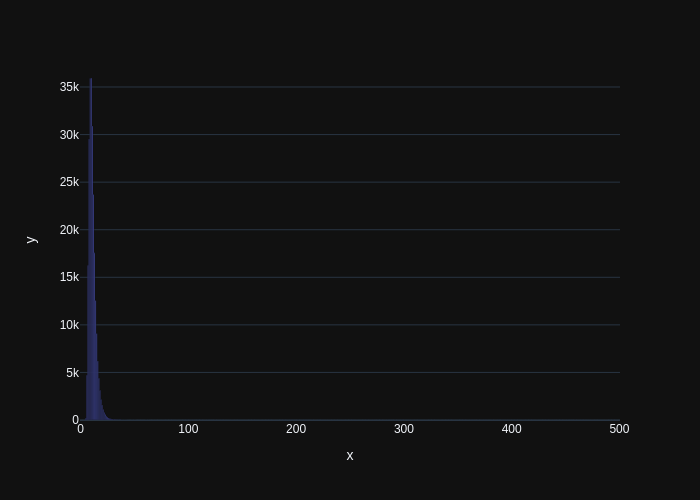

In [19]:
all_tokens = en_tokens_len.tolist()+es_tokens_len.tolist()
counts,bins = np.histogram(all_tokens,bins=np.linspace(0,500,501))
fig = px.bar(y=[0]+counts.tolist(),x=bins.tolist())
fig.show("png")

In [20]:
MAX_TOKENS = 128
def prepare_ds(en,es):
    en = up_stream_processing(en,"en")
    es = up_stream_processing(es,"es")
    en = en[:,:MAX_TOKENS]
    es = es[:,:MAX_TOKENS]
    return (en.to_tensor(),es[:,:-1].to_tensor()),es[:,1:].to_tensor()

In [21]:
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE
en_array = np.array(en_text)
es_array = np.array(es_text)
all_indices = np.random.uniform(size=len(en_text))
train_mask = all_indices <= 0.8
valid_mask = (all_indices > 0.8) & (all_indices <= 0.95)
test_mask = all_indices > 0.95
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((en_array[train_mask],es_array[train_mask]))
    .shuffle(len(en_text))
    .batch(BATCH_SIZE)
    .map(prepare_ds)
    .prefetch(AUTO)
)
valid_ds = (
    tf.data.Dataset
    .from_tensor_slices((en_array[valid_mask],es_array[valid_mask]))
    .shuffle(len(en_text))
    .batch(BATCH_SIZE)
    .map(prepare_ds)
    .prefetch(AUTO)
)
test_ds = (
    tf.data.Dataset
    .from_tensor_slices((en_array[test_mask],es_array[test_mask]))
    .shuffle(len(en_text))
    .batch(BATCH_SIZE)
    .map(prepare_ds)
    .prefetch(AUTO)
)

In [22]:
for (en_in,es_in),tar_in in train_ds.take(1):
    print(en_in.shape,es_in.shape,tar_in.shape)
    print(es_in[0,:10])
    print(tar_in[0,:10])

(64, 20) (64, 22) (64, 22)
tf.Tensor([   2   84   37  226   73   25  136 1009 4362   41], shape=(10,), dtype=int64)
tf.Tensor([  84   37  226   73   25  136 1009 4362   41   37], shape=(10,), dtype=int64)
